In [1]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
from vivarium import Artifact
import scipy.stats as stats
import scipy
from db_queries import get_ids, get_covariate_estimates

# IFA/MMS Gestational Age Shift Calculation
Adapted from https://github.com/ihmeuw/vivarium_research_nutrition_optimization/blob/data_prep/data_prep/antenatal_interventions/Gestational%20age%20shifts.ipynb

In [2]:
# first load baseline coverage data

In [3]:
# this data comes from Annie Haakkenstad's Health Systems estimates and represents oral iron in pregnancy among those who attend ANC 
ifa = pd.read_csv('/snfs1/Project/simulation_science/mnch_grant/MNCNH portfolio/anc_iron_prop_st-gpr_results_aggregates_scaled2025-05-30.csv')
ifa = ifa.loc[(ifa.location_id.isin([179,214,165])) & (ifa.year_id==2020)].reset_index()
ifa_draws = pd.DataFrame()
for i in ifa.index:
    temp = ifa.loc[i]
    draws = scipy.stats.norm(temp['mean'], (temp['upper'] - temp['lower'])/2/1.96).rvs(size=1_000)
    ifa_draws[temp.location_id] = draws
ifa_draws = pd.DataFrame(ifa_draws.stack()).reset_index().rename(columns={'level_0':'draw','level_1':'location_id',0:'value'})
ifa_draws['draw'] = 'draw_' + ifa_draws.draw.astype(str)
ifa_draws['location_id'] = ifa_draws.location_id.astype(int)
ifa_draws.groupby(['location_id'])['value'].describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
location_id,,,,,,,,
165,1000.0,0.655973,0.018721,0.593983,0.617014,0.656662,0.690426,0.710535
179,1000.0,0.518097,0.018915,0.461863,0.482125,0.518371,0.554903,0.576965
214,1000.0,0.786020,0.015754,0.729448,0.755141,0.786672,0.815145,0.840341


In [4]:
# load ANC1 so that we can adjust accoringly
anc = get_covariate_estimates(location_id=[179, 214, 165], 
                        year_id=2021, 
                        release_id=9, 
                        covariate_id=7)
anc = anc.set_index('location_id')[[c for c in anc.columns if 'value' in c and c != 'location_id']].reset_index()
anc

,location_id,mean_value,lower_value,upper_value
0,165,0.907563,0.820658,0.960192
1,179,0.756886,0.664525,0.829689
2,214,0.743100,0.719485,0.765026


In [5]:
anc_draws = pd.DataFrame()
for i in anc.index:
    temp = anc.loc[i]
    draws = scipy.stats.norm(temp.mean_value, (temp.upper_value - temp.lower_value)/2/1.96).rvs(size=1_000)
    anc_draws[temp.location_id] = draws
anc_draws = pd.DataFrame(anc_draws.stack()).reset_index().rename(columns={'level_0':'draw','level_1':'location_id',0:'value'})
anc_draws['draw'] = 'draw_' + anc_draws.draw.astype(str)
anc_draws['location_id'] = anc_draws.location_id.astype(int)
anc_draws.groupby(['location_id'])['value'].describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
location_id,,,,,,,,
165,1000.0,0.908576,0.035360,0.810032,0.837275,0.909878,0.977094,1.006501
179,1000.0,0.757191,0.041555,0.624968,0.674208,0.758047,0.833728,0.899024
214,1000.0,0.743439,0.011645,0.705725,0.720966,0.743463,0.765585,0.779903


In [6]:
baseline_ifa = (anc_draws.rename(columns={'value':'anc'})
                .merge(ifa_draws.rename(columns={'value':'ifa'}), on=['location_id','draw']))
baseline_ifa['value'] = baseline_ifa.anc * baseline_ifa.ifa
baseline_ifa = baseline_ifa.drop(columns=['anc','ifa'])
baseline_ifa

,draw,location_id,value
0,draw_0,165,0.575460
1,draw_0,179,0.427838
2,draw_0,214,0.570492
3,draw_1,165,0.588880
4,draw_1,179,0.426076
...,...,...,...
2995,draw_998,179,0.376589
2996,draw_998,214,0.549415
2997,draw_999,165,0.575537
2998,draw_999,179,0.446333


In [7]:
baseline_ifa.groupby('location_id')['value'].describe(percentiles=[0.025,0.975]).filter(['mean','2.5%','97.5%'])

,mean,2.5%,97.5%
location_id,,,
165,0.596037,0.540779,0.654674
179,0.392304,0.340313,0.443353
214,0.584354,0.555461,0.614377


In [8]:
# IRA OR: 0.9 (0.86, 0.95) relative to no IFA
# MMS RR: 0.91 (0.84, 0.99) relative to IFA... UPDATED FROM: 0.95 (0.90, 1.01) relative to IFA
# MMS VERY PRETERM: RR = 0.81 (0.71, 0.93) relative to IFA

# baseline ifa coverage for ethiopia... 31.8%
# Alix Q: These RRs didn't update with the new Cochrane review, but our baseline coverage estimates were updated since this notebook was first written for the Nutrition Optimization project.
# I am confused where this 31.8% number comes from, in the old notebook it looks like 45.1%?

In [9]:
# generate lognormal distribution of IFA OR

In [10]:
def lognorm_from_median_lower_upper(median, lower, upper, quantile_ranks=(0.025,0.975)):
  """Returns a frozen lognormal distribution with the specified median, such that
  the values (lower, upper) are approximately equal to the quantiles with ranks
  (quantile_ranks[0], quantile_ranks[1]). More precisely, if q0 and q1 are
  the quantiles of the returned distribution with ranks quantile_ranks[0]
  and quantile_ranks[1], respectively, then q1/q0 = upper/lower. If the
  quantile ranks are symmetric about 0.5, lower and upper will coincide with
  q0 and q1 precisely when median^2 = lower*upper.
  """
  # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
  # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
  # We will determine sigma from the two specified quantiles lower and upper.

  # mean (and median) of the normal random variable Y = log(X)
  mu = np.log(median)
  # quantiles of the standard normal distribution corresponding to quantile_ranks
  stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
  # quantiles of Y = log(X) corresponding to the quantiles (lower, upper) for X
  norm_quantiles = np.log([lower, upper])
  # standard deviation of Y = log(X) computed from the above quantiles for Y
  # and the corresponding standard normal quantiles
  sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
  # Frozen lognormal distribution for X = exp(Y)
  # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
  return stats.lognorm(s=sigma, scale=median)

In [11]:
dist = lognorm_from_median_lower_upper(0.9, 0.86, 0.96, quantile_ranks=(0.025,0.975))
dist.ppf(0.975)

0.9508869788316736

In [12]:
dist.ppf(0.025)

0.8518362518700411

In [13]:
dist.ppf(0.5)

0.9

In [14]:
dist.mean()

0.9003544331065376

In [15]:
ifa_rr_draws = pd.DataFrame()
ifa_rr_draws['draw'] = [f'draw_{x}' for x in list(range(0,1000))]
ifa_rr_draws['rr'] = dist.rvs(size=1000)
#ifa_rr_draws['coverage'] = 
ifa_rr_draws

,draw,rr
0,draw_0,0.927062
1,draw_1,0.908809
2,draw_2,0.893626
3,draw_3,0.885823
4,draw_4,0.884670
...,...,...
995,draw_995,0.901604
996,draw_996,0.897929
997,draw_997,0.869787
998,draw_998,0.877502


In [16]:
ifa_rr_draws.rr.describe(percentiles=[0.025,0.975])

count    1000.000000
mean        0.900772
std         0.026243
min         0.825437
2.5%        0.849257
50%         0.900279
97.5%       0.951352
max         0.977790
Name: rr, dtype: float64

# First, let's just load in LBWSG exposure data

In [17]:
os.listdir('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model13.1')

['nigeria.hdf', 'pakistan.hdf', 'ethiopia.hdf']

In [18]:
art = Artifact('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model13.1/ethiopia.hdf',
               filter_terms=['year_start == 2021', f'child_age_end <= 5'])

art_exposure = art.load(f'risk_factor.low_birth_weight_and_short_gestation.exposure')['draw_0'].reset_index()

# The below code is from the old notebook, but I am confused why it filters to child_age_end==0, that returns 0 rows with this new artifact (Alix Q)
# = art_exposure.loc[(art_exposure.sex_of_child=='Female')&(art_exposure.child_age_end==0)][['parameter']] 
# art_cats = art.load(f'risk_factor.low_birth_weight_and_short_gestation.categories')
# art_exposure['bw_start'] = np.nan
# art_exposure['bw_end'] = np.nan
# art_exposure['ga_start'] = np.nan
# art_exposure['ga_end'] = np.nan

# for i in art_exposure.index:
#     art_exposure['bw_start'][i] = art_cats[art_exposure.parameter[i]].split('wks, [')[1].split(',')[0]
#     art_exposure['bw_end'][i] = art_cats[art_exposure.parameter[i]].split('wks, [')[1].split(', ')[1].split(')')[0]
#     art_exposure['ga_start'][i] = art_cats[art_exposure.parameter[i]].split('- [')[1].split(', ')[0]
#     art_exposure['ga_end'][i] = art_cats[art_exposure.parameter[i]].split('- [')[1].split(') wks')[0].split(', ')[1]

# The below code is copied from 2025_2_27_lbwsg_distribution.ipynb but I think it does the same thing as the above code, but using Nathaniel's CSV rather than the artifact
# Load Nathaniel's CSV that map LBWSG categories to BW and GA continuous values
art_exposure = pd.read_csv('/snfs1/Project/simulation_science/mnch_grant/MNCNH portfolio/lbwsg_category_data_gbd_2021.csv').rename(columns={'lbwsg_category':'parameter'})
art_exposure = art_exposure[['parameter','ga_start','ga_end','bw_start','bw_end']] # Only keep the columns that we need right now 
art_exposure

,parameter,ga_start,ga_end,bw_start,bw_end
0,cat2,0,24,0,500
1,cat8,0,24,500,1000
2,cat10,24,26,500,1000
3,cat11,26,28,500,1000
4,cat14,30,32,500,1000
5,cat15,28,30,500,1000
6,cat17,26,28,1000,1500
7,cat19,34,36,1000,1500
8,cat20,28,30,1500,2000
9,cat21,28,30,1000,1500


In [19]:
exposure = get_draws(release_id=9,
               year_id=2021,
               location_id=[179,214,165], 
               age_group_id=164, # birth
               gbd_id_type='rei_id',
               gbd_id=339,
               source='exposure')
exp = exposure.merge(art_exposure, on='parameter')
exp = exp.drop(columns=['rei_id','modelable_entity_id','year_id','measure_id','metric_id','model_version_id'])
exp['ga_start'] = exp.ga_start.astype(float)
exp['ga_end'] = exp.ga_end.astype(float)
exp

,location_id,age_group_id,sex_id,parameter,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,...,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,ga_start,ga_end,bw_start,bw_end
0,214,164,1,cat2,0.000764,0.000672,0.000597,0.000693,0.000639,0.000693,...,0.000639,0.000598,0.000698,0.000615,0.000644,0.000764,0.0,24.0,0,500
1,214,164,2,cat2,0.000585,0.000604,0.000623,0.000599,0.000606,0.000720,...,0.000560,0.000607,0.000620,0.000591,0.000636,0.000585,0.0,24.0,0,500
2,179,164,2,cat2,0.000458,0.000529,0.000601,0.000587,0.000732,0.000557,...,0.000559,0.000699,0.000479,0.000419,0.000779,0.000458,0.0,24.0,0,500
3,179,164,1,cat2,0.000614,0.000646,0.000557,0.000669,0.000643,0.000719,...,0.000579,0.000583,0.000836,0.000789,0.000601,0.000614,0.0,24.0,0,500
4,165,164,2,cat2,0.000930,0.001126,0.000633,0.000743,0.001107,0.000812,...,0.000864,0.000912,0.001164,0.001820,0.001025,0.000930,0.0,24.0,0,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,214,164,2,cat123,0.002853,0.002730,0.002958,0.002907,0.002922,0.002877,...,0.002893,0.002876,0.002969,0.002885,0.002821,0.002853,40.0,42.0,1500,2000
344,179,164,2,cat123,0.003221,0.002773,0.003621,0.003073,0.002963,0.003355,...,0.003620,0.003170,0.002814,0.003194,0.003726,0.003221,40.0,42.0,1500,2000
345,179,164,1,cat123,0.002473,0.002720,0.002787,0.002449,0.002858,0.003094,...,0.002677,0.002537,0.002974,0.002615,0.002849,0.002473,40.0,42.0,1500,2000
346,165,164,2,cat123,0.005273,0.005725,0.005597,0.006084,0.006699,0.006150,...,0.004707,0.005095,0.005743,0.005096,0.005215,0.005273,40.0,42.0,1500,2000


In [20]:
data = exp.set_index([c for c in exp.columns if 'draw' not in c]).stack().reset_index()
data = data.rename(columns={'level_8':'draw',0:'exposure'})
data = data.merge(ifa_rr_draws, on='draw')
    # TAKE MEAN ACROSS SEXES
        # WEIGHT ACCORDING TO SEX RATIO?
data = data.groupby(['location_id','age_group_id','parameter','bw_start','bw_end',
                    'ga_start','ga_end','draw','rr']).exposure.mean().reset_index()
data = data.merge(baseline_ifa, on=['location_id','draw'])
data

,location_id,age_group_id,parameter,bw_start,bw_end,ga_start,ga_end,draw,rr,exposure,value
0,165,164,cat10,500,1000,24.0,26.0,draw_0,0.927062,0.000901,0.575460
1,165,164,cat106,1000,1500,36.0,37.0,draw_0,0.927062,0.000995,0.575460
2,165,164,cat11,500,1000,26.0,28.0,draw_0,0.927062,0.001250,0.575460
3,165,164,cat116,1000,1500,38.0,40.0,draw_0,0.927062,0.007623,0.575460
4,165,164,cat117,1500,2000,38.0,40.0,draw_0,0.927062,0.017419,0.575460
...,...,...,...,...,...,...,...,...,...,...,...
173995,214,164,cat88,2500,3000,30.0,32.0,draw_999,0.868576,0.006066,0.589911
173996,214,164,cat89,3000,3500,30.0,32.0,draw_999,0.868576,0.001635,0.589911
173997,214,164,cat90,3500,4000,30.0,32.0,draw_999,0.868576,0.000309,0.589911
173998,214,164,cat95,3000,3500,32.0,34.0,draw_999,0.868576,0.005547,0.589911


In [21]:
# ok, so to generate uncovered distribution...
    # uncovered mean GA = population mean GA - coverage * GA_shift
    # in other words, shift everything down by shift multiplied by coverage

In [22]:
def calculate_rr_from_shift(draw, location_id):
    exp = data.loc[(data.draw==f'draw_{draw}')&(data.location_id==location_id)]
    coverage = exp['value'].values[0]
    exp = exp.set_index([c for c in data.columns if 'ga_' not in c])
    def shift_optimization(shift):
        exp_uncovered = (exp - (shift * coverage)).reset_index()
        exp_uncovered['frac_ptb'] = np.where(exp_uncovered.ga_start >= 37, 0,
                                        np.where(exp_uncovered.ga_end < 37, 1,
                                                (37 - exp_uncovered.ga_start)/(exp_uncovered.ga_end - exp_uncovered.ga_start)
                                                ))
        uncovered_ptb = (exp_uncovered.exposure * exp_uncovered.frac_ptb).sum()
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered['frac_ptb'] = np.where(exp_covered.ga_start >= 37, 0,
                                            np.where(exp_covered.ga_end < 37, 1,
                                                    (37 - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)
                                                    ))
        covered_ptb = (exp_covered.exposure * exp_covered.frac_ptb).sum()
        rr = covered_ptb / uncovered_ptb
        return np.abs(rr - exp_covered.rr[0])
    return scipy.optimize.minimize_scalar(shift_optimization, bounds=(-1, 2), method='bounded')['x']

In [23]:
# Test with one draw and one country first
test_draw = 1
calculate_rr_from_shift(test_draw, 179) 

# Great, looks like it works? Now let's calculate with all draws and all countries

0.11980193118698043

In [28]:
%%time 

#ethiopia_ifa_shifts = []
#nigeria_ifa_shifts = []
pakistan_ifa_shifts = []
for draw in list(range(0,1000)):
    #ethiopia_ifa_shifts.append(calculate_rr_from_shift(draw, 179))
    #nigeria_ifa_shifts.append(calculate_rr_from_shift(draw, 214))
    pakistan_ifa_shifts.append(calculate_rr_from_shift(draw, 165))

CPU times: user 2min 23s, sys: 0 ns, total: 2min 23s
Wall time: 2min 23s


In [26]:
# ethiopia
print(np.array(ethiopia_ifa_shifts).mean().round(2), 
      np.quantile(np.array(ethiopia_ifa_shifts), 0.025).round(2),
      np.quantile(np.array(ethiopia_ifa_shifts), 0.975).round(2))

0.14 0.06 0.22


In [27]:
# nigeria
print(np.array(nigeria_ifa_shifts).mean().round(2), 
      np.quantile(np.array(nigeria_ifa_shifts), 0.025).round(2),
      np.quantile(np.array(nigeria_ifa_shifts), 0.975).round(2))

0.11 0.05 0.17


In [29]:
# pakistan
print(np.array(pakistan_ifa_shifts).mean().round(2), 
      np.quantile(np.array(pakistan_ifa_shifts), 0.025).round(2),
      np.quantile(np.array(pakistan_ifa_shifts), 0.975).round(2))

0.11 0.05 0.17


In [ ]:
# ok, IFA shifts for Ethiopia: +0.14 (95% UI: 0.06, 0.22) weeks
# IFA shifts for Nigeria and Pakistan: +0.11 (95% UI: 0.05, 0.17) weeks
# Alix Q: Is it weird that Nigeria and Pakistan are the same?

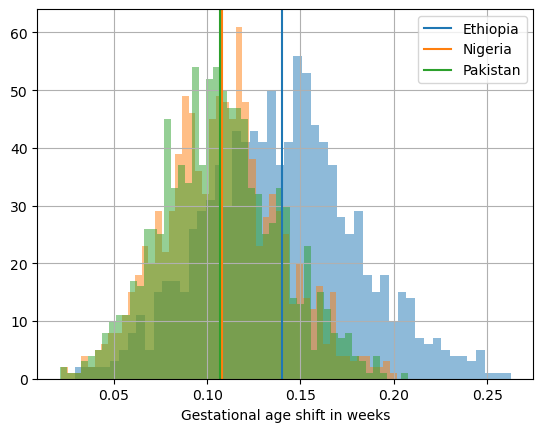

In [30]:
import matplotlib.pyplot as plt
plt.hist(ethiopia_ifa_shifts, bins=50, alpha=0.5)
plt.hist(nigeria_ifa_shifts, bins=50, alpha=0.5)
plt.hist(pakistan_ifa_shifts, bins=50, alpha=0.5)
plt.axvline(np.array(ethiopia_ifa_shifts).mean(), color='tab:blue')
plt.axvline(np.array(nigeria_ifa_shifts).mean(), color='tab:orange')
plt.axvline(np.array(pakistan_ifa_shifts).mean(), color='tab:green')
plt.grid()
plt.legend(['Ethiopia','Nigeria','Pakistan'])
plt.xlabel('Gestational age shift in weeks')
plt.show()

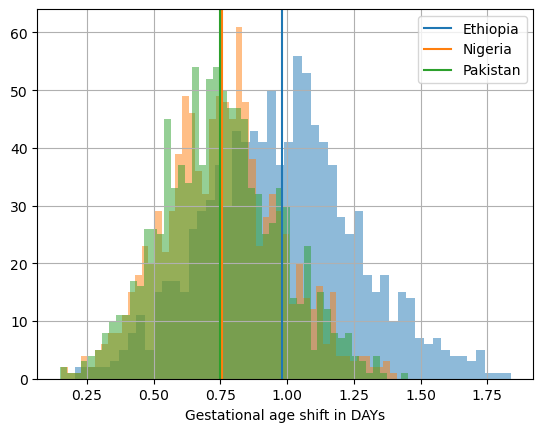

In [31]:
import matplotlib.pyplot as plt
plt.hist([x*7 for x in ethiopia_ifa_shifts], bins=50, alpha=0.5)
plt.hist([x*7 for x in nigeria_ifa_shifts], bins=50, alpha=0.5)
plt.hist([x*7 for x in pakistan_ifa_shifts], bins=50, alpha=0.5)
plt.axvline(np.array(ethiopia_ifa_shifts).mean() * 7, color='tab:blue')
plt.axvline(np.array(nigeria_ifa_shifts).mean() * 7, color='tab:orange')
plt.axvline(np.array(pakistan_ifa_shifts).mean() * 7, color='tab:green')
plt.grid()
#plt.xlim(0,0.4)
plt.legend(['Ethiopia','Nigeria','Pakistan'])
plt.xlabel('Gestational age shift in DAYs')
plt.show()

In [32]:
ifa_shifts = pd.DataFrame()
ifa_shifts[179] = ethiopia_ifa_shifts
ifa_shifts[214] = nigeria_ifa_shifts
ifa_shifts[165] = pakistan_ifa_shifts
ifa_shifts = ifa_shifts.stack().reset_index().rename(columns={'level_0':'draw','level_1':'location_id',0:'value'})
ifa_shifts['draw'] = 'draw_' + ifa_shifts.draw.astype(str)
ifa_shifts

,draw,location_id,value
0,draw_0,179,0.094725
1,draw_0,214,0.078499
2,draw_0,165,0.077325
3,draw_1,179,0.119802
4,draw_1,214,0.098493
...,...,...,...
2995,draw_998,214,0.141419
2996,draw_998,165,0.129681
2997,draw_999,179,0.174946
2998,draw_999,214,0.146244


In [33]:
ifa_shifts.to_csv('ifa_ga_shifts.csv')

In [34]:
ifa_shifts = pd.read_csv('ifa_ga_shifts.csv').drop(columns='Unnamed: 0')
ifa_shifts

,draw,location_id,value
0,draw_0,179,0.094725
1,draw_0,214,0.078499
2,draw_0,165,0.077325
3,draw_1,179,0.119802
4,draw_1,214,0.098493
...,...,...,...
2995,draw_998,214,0.141419
2996,draw_998,165,0.129681
2997,draw_999,179,0.174946
2998,draw_999,214,0.146244


In [35]:
exp_prepped = exp.set_index([c for c in exp.columns if 'draw' not in c]).stack().reset_index()
exp_prepped = exp_prepped.rename(columns={'level_8':'draw',0:'exposure'})
uncovered_shift = (-ifa_shifts.set_index(['location_id','draw']) * baseline_ifa.set_index(['location_id','draw']))
uncovered_shift = uncovered_shift.reset_index().rename(columns={'value':'uncovered_shift'})
uncovered_exp = exp_prepped.merge(uncovered_shift, on=['location_id','draw'])
uncovered_exp['ga_start'] = uncovered_exp.ga_start + uncovered_exp.uncovered_shift
uncovered_exp['ga_end'] = uncovered_exp.ga_end + uncovered_exp.uncovered_shift
uncovered_exp['frac_ptb'] = np.where(uncovered_exp.ga_start >= 37, 0,
                                    np.where(uncovered_exp.ga_end < 37, 1, 
                                            (37 - uncovered_exp.ga_start) / (uncovered_exp.ga_end - uncovered_exp.ga_start)))
uncovered_exp['exposure_ptb'] = uncovered_exp.frac_ptb * uncovered_exp.exposure
uncovered_ptb = uncovered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb']]
uncovered_ptb.groupby('location_id').describe(percentiles=[0.025,0.975])[['exposure_ptb']]

/tmp/ipykernel_3250253/33346034.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  uncovered_ptb = uncovered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb']]


exposure_ptb                                                    \
                   count      mean       std       min      2.5%       50%   
location_id                                                                  
165               1000.0  0.359073  0.010826  0.327353  0.338530  0.358767   
179               1000.0  0.354350  0.009276  0.326079  0.336656  0.354557   
214               1000.0  0.358633  0.009495  0.333077  0.341258  0.358496   

                                 
                97.5%       max  
location_id                      
165          0.380578  0.394437  
179          0.373278  0.388578  
214          0.377230  0.388692

In [63]:
covered_shift = (-ifa_shifts.set_index(['location_id','draw']) * baseline_ifa.set_index(['location_id','draw'])
                + ifa_shifts.set_index(['location_id','draw']))
covered_shift = covered_shift.reset_index().rename(columns={'value':'covered_shift'})
covered_exp = exp_prepped.merge(covered_shift, on=['location_id','draw'])
covered_exp['ga_start'] = covered_exp.ga_start + covered_exp.covered_shift
covered_exp['ga_end'] = covered_exp.ga_end + covered_exp.covered_shift
covered_exp['frac_ptb'] = np.where(covered_exp.ga_start > 37, 0,
                                    np.where(covered_exp.ga_end < 37, 1, 
                                            (37 - covered_exp.ga_start) / (covered_exp.ga_end - covered_exp.ga_start)))
covered_exp['exposure_ptb'] = covered_exp.frac_ptb * covered_exp.exposure

# Add exposure_vptb calculation for MMS validation
covered_exp['frac_vptb'] = np.where(covered_exp.ga_start >= 32, 0,
                                    np.where(covered_exp.ga_end < 32, 1, 
                                            (32 - covered_exp.ga_start) / (covered_exp.ga_end - covered_exp.ga_start)))
covered_exp['exposure_vptb'] = covered_exp.frac_vptb * covered_exp.exposure

covered_ptb = covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb', 'exposure_vptb']]
covered_ptb.groupby('location_id').describe(percentiles=[0.025,0.975])[['exposure_ptb']]

/tmp/ipykernel_3250253/3696864408.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  covered_ptb = covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb', 'exposure_vptb']]


exposure_ptb                                                    \
                   count      mean       std       min      2.5%       50%   
location_id                                                                  
165               1000.0  0.323191  0.004564  0.308315  0.314389  0.323115   
179               1000.0  0.318976  0.004510  0.304703  0.309772  0.319057   
214               1000.0  0.322802  0.001893  0.317100  0.319061  0.322882   

                                 
                97.5%       max  
location_id                      
165          0.332524  0.338018  
179          0.327665  0.332755  
214          0.326363  0.328801

In [64]:
print('Validation target is: ',ifa_rr_draws.rr.mean().round(3),
      ' (95% CI: ',ifa_rr_draws.rr.quantile(0.025).round(3), 
      ", ",ifa_rr_draws.rr.quantile(0.975).round(3), ")")
ifa_rrs_observed = covered_ptb / uncovered_ptb
ifa_rrs_observed.groupby('location_id')['exposure_ptb'].describe(percentiles=[0.025,0.975]).filter(['mean','2.5%','97.5%'])

Validation target is:  0.901  (95% CI:  0.849 ,  0.951 )


,mean,2.5%,97.5%
location_id,,,
165,0.900772,0.849258,0.951353
179,0.900772,0.849257,0.951352
214,0.900772,0.849257,0.951351


# Ok now for MMS

RR for preterm birth (37 weeks) relative to IFA: 0.91 (0.84, 0.99)... updated from: 0.95 (0.90, 1.01)

RR for very preterm birth (32 weeks) relative to IFA: 0.81 (0.71, 0.93)

In [65]:
mms_pt_dist = lognorm_from_median_lower_upper(0.91, 0.84, 0.99, quantile_ranks=(0.025,0.975))
mms_pt_rr_draws = pd.DataFrame()
mms_pt_rr_draws['draw'] = [f'draw_{x}' for x in list(range(0,1000))]
mms_pt_rr_draws['rr'] = mms_pt_dist.rvs(size=1000)
mms_pt_rr_draws.describe(percentiles=[0.025,0.975])

,rr
count,1000.000000
mean,0.911483
std,0.038467
min,0.800388
2.5%,0.841890
50%,0.911095
97.5%,0.990781
max,1.046197


In [66]:
mms_vpt_dist = lognorm_from_median_lower_upper(0.81, 0.71, 0.93, quantile_ranks=(0.025,0.975))
mms_vpt_rr_draws = pd.DataFrame()
mms_vpt_rr_draws['draw'] = [f'draw_{x}' for x in list(range(0,1000))]
mms_vpt_rr_draws['rr'] = mms_vpt_dist.rvs(size=1000)
mms_vpt_rr_draws.describe(percentiles=[0.025,0.975])

,rr
count,1000.000000
mean,0.810772
std,0.055522
min,0.659775
2.5%,0.712367
50%,0.808072
97.5%,0.923484
max,1.009578


In [67]:
ifa_exp = covered_exp.copy().drop(columns='covered_shift')
ifa_exp = ifa_exp.groupby([c for c in ifa_exp if c!='sex_id' and 'exposure' not in c]).mean().reset_index()
ifa_exp['frac_vptb'] = np.where(ifa_exp.ga_start >= 32, 0,
                                        np.where(ifa_exp.ga_end < 32, 1,
                                                (32 - ifa_exp.ga_start)/(ifa_exp.ga_end - ifa_exp.ga_start)
                                                ))
ifa_exp['exposure_vptb'] = ifa_exp.frac_vptb * ifa_exp.exposure
data_mms_pt = ifa_exp.merge(mms_pt_rr_draws, on='draw').drop(columns=['frac_vptb'])
data_mms_vpt = ifa_exp.merge(mms_vpt_rr_draws, on='draw')#.drop(columns=['frac_ptb'])
data_mms_pt.head()

,location_id,age_group_id,parameter,ga_start,ga_end,bw_start,bw_end,draw,frac_ptb,sex_id,exposure,exposure_ptb,exposure_vptb,rr
0,165,164,cat10,24.008027,26.008027,500,1000,draw_975,1.000000,1.5,0.000580,0.000580,0.000580,0.936252
1,165,164,cat106,36.008027,37.008027,1000,1500,draw_975,0.991973,1.5,0.000867,0.000860,0.000000,0.936252
2,165,164,cat11,26.008027,28.008027,500,1000,draw_975,1.000000,1.5,0.000942,0.000942,0.000942,0.936252
3,165,164,cat116,38.008027,40.008027,1000,1500,draw_975,0.000000,1.5,0.008175,0.000000,0.000000,0.936252
4,165,164,cat117,38.008027,40.008027,1500,2000,draw_975,0.000000,1.5,0.015875,0.000000,0.000000,0.936252


In [68]:
def mms_shift(draw, location_id, ptb = True):
    if ptb:
        threshold = 'ptb'
        threshold_val = 37
        data = data_mms_pt.copy()
    else:
        threshold = 'vptb'
        threshold_val = 32
        data = data_mms_vpt.copy()
    exp_uncovered = data.loc[(data.draw==f'draw_{draw}')&(data.location_id==location_id)]
    uncovered_low = exp_uncovered[f'exposure_{threshold}'].sum()
    def shift_optimization(shift):
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered[f'frac_{threshold}'] = np.where(exp_covered.ga_start >= threshold_val, 0,
                                            np.where(exp_covered.ga_end < threshold_val, 1,
                                                    (threshold_val - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)
                                                    ))
        covered_low = (exp_covered.exposure * exp_covered[f'frac_{threshold}']).sum()
        rr = covered_low / uncovered_low
        return np.abs(rr - exp_covered.rr[0])
    return scipy.optimize.minimize_scalar(shift_optimization, bounds=(-2, 2), method='bounded')['x']

In [69]:
draw = 0
location_id = 179

mms_shift(draw, location_id, ptb = True)

0.4318249627528232

In [70]:
mms_shift(draw, location_id, ptb = False)

0.6797865689873516

In [71]:
location_id=179

vptb_shifts = []
ptb_shifts = []
for draw in list(range(0,100)):
    vptb_shifts.append(mms_shift(draw, location_id, ptb = False))
    ptb_shifts.append(mms_shift(draw, location_id, ptb = True))

In [72]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'MMS gestational age shifts for Ethiopia, 100 draws')

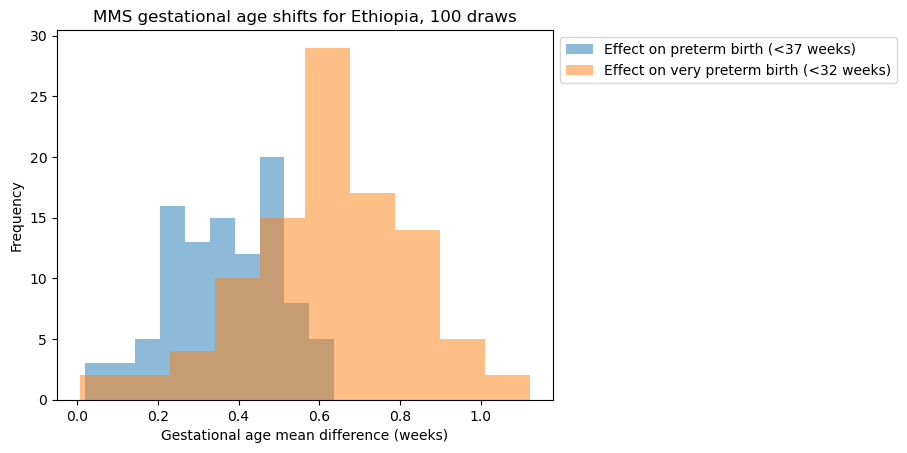

In [73]:
plt.hist(ptb_shifts, alpha=0.5)
plt.hist(vptb_shifts, alpha=0.5)
plt.legend(['Effect on preterm birth (<37 weeks)',
           'Effect on very preterm birth (<32 weeks)'], bbox_to_anchor=[1,1])
plt.xlabel('Gestational age mean difference (weeks)')
plt.ylabel('Frequency')
plt.title("MMS gestational age shifts for Ethiopia, 100 draws")

    # conclusion: we will overestimate the effect of MMS on preterm birth (<37 weeks)
    # if we move forward with the GA shifts that accurately replicates the effect
    # on very preterm birth (<32 weeks)
    
    # and likewise, we will underestimate the effect of MMS on VPTB if we use the shifts
    # from the PTB impacts
    
        # SHOULD WE JUST TAKE THE OVERLAPPING REGION? I think no

In [74]:
# ok let's try some sort of joint approach?
    # first, apply the VPTB shift relative to IFA
    # then, for those who are not VPTB, find a new shift to correct for initial overestimate

In [75]:
def mms_double_shift(draw, location_id):
    
    ptb_rr = mms_pt_rr_draws.loc[mms_pt_rr_draws.draw==f'draw_{draw}'].rr.values[0]
    vptb_rr = mms_vpt_rr_draws.loc[mms_vpt_rr_draws.draw==f'draw_{draw}'].rr.values[0]
    
    exp_uncovered = data_mms_vpt.loc[(data_mms_vpt.draw==f'draw_{draw}')&(data_mms_vpt.location_id==location_id)]
    uncovered_vptb = exp_uncovered.exposure_vptb.sum()
    uncovered_ptb = exp_uncovered.exposure_ptb.sum()
    def vptb_shift_optimization(shift):
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered['frac_vptb'] = np.where(exp_covered.ga_start >= 32, 0,
                                            np.where(exp_covered.ga_end < 32, 1,
                                                    (32 - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)))
        covered_vptb = (exp_covered.exposure * exp_covered['frac_vptb']).sum()
        rr = covered_vptb / uncovered_vptb
        return np.abs(rr - vptb_rr)
    vptb_shift = scipy.optimize.minimize_scalar(vptb_shift_optimization, bounds=(-2, 2), method='bounded')['x']
    mms1 = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + vptb_shift
    mms1 = mms1.reset_index()
    mms1['frac_vptb'] = np.where(mms1.ga_start >= 32, 0,
                                            np.where(mms1.ga_end < 32, 1,
                                                    (32 - mms1.ga_start)/(mms1.ga_end - mms1.ga_start)))
    mms1['frac_ptb'] = np.where(mms1.ga_start >= 37, 0,
                                            np.where(mms1.ga_end < 37, 1,
                                                    (37 - mms1.ga_start)/(mms1.ga_end - mms1.ga_start)))
    mms1_vptb = (mms1.exposure * mms1.frac_vptb).sum()
    mms1_ptb = (mms1.exposure * mms1.frac_ptb).sum()
    
    def second_shift_optimization(shift):
        mms2 = mms1.copy()
        mms2['ga_start'] = np.where(mms2.ga_start < (32 - shift), mms2.ga_start, mms2.ga_start + shift)
        mms2['ga_end'] = np.where(mms2.ga_start < (32 - shift), mms2.ga_end, mms2.ga_end + shift)
        mms2 = mms2.reset_index()
        mms2['frac_ptb'] = np.where(mms2.ga_start >= 37, 0,
                                            np.where(mms2.ga_end < 37, 1,
                                                    (37 - mms2.ga_start)/(mms2.ga_end - mms2.ga_start)))
        mms2['frac_vptb'] = np.where(mms2.ga_start >= 32, 0,
                                            np.where(mms2.ga_end < 32, 1,
                                                    (32 - mms2.ga_start)/(mms2.ga_end - mms2.ga_start)))
        mms2_ptb = (mms2.exposure * mms2['frac_ptb']).sum()
        mms2_vptb = (mms2.exposure * mms2.frac_vptb).sum()
        rr = mms2_ptb / uncovered_ptb
        return np.abs(rr - ptb_rr)
    second_shift = scipy.optimize.minimize_scalar(second_shift_optimization, bounds=(-5, 5), method='bounded')['x']
    
    return vptb_shift, second_shift

In [76]:
mms_double_shift(draw, location_id)

(0.8605195857435142, -0.40207079189953104)

In [77]:
# rules for applying MMS shifts:
    # apply first shift to everyone who gets MMS
    # if their shifted GA is greater than (32 + second_shift):
        # apply the second shift
    # otherwise, that's their final GA

In [78]:
ethiopia_mms_shifts = pd.DataFrame()
for draw in list(range(0,1000)):
    shift1, shift2 = mms_double_shift(draw, 179)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    ethiopia_mms_shifts = pd.concat([ethiopia_mms_shifts, temp], ignore_index=True)
ethiopia_mms_shifts

,draw,shift1,shift2
0,draw_0,0.679787,-0.247961
1,draw_1,0.897761,-0.746363
2,draw_2,0.005840,0.226187
3,draw_3,0.667505,-0.378774
4,draw_4,0.684519,-0.249751
...,...,...,...
995,draw_995,0.527343,-0.343967
996,draw_996,0.538920,-0.223173
997,draw_997,0.416212,0.272785
998,draw_998,0.702361,-0.218961


In [79]:
ethiopia_mms_shifts.describe()

,shift1,shift2
count,1000.000000,1000.000000
mean,0.624183,-0.285302
std,0.183673,0.238304
min,-0.031407,-1.031995
25%,0.499841,-0.443589
50%,0.633869,-0.293318
75%,0.746427,-0.122489
max,1.123616,0.423716


In [80]:
location_id=214
nigeria_mms_shifts = pd.DataFrame()
for draw in list(range(0,1000)):
    shift1, shift2 = mms_double_shift(draw, location_id)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    nigeria_mms_shifts = pd.concat([nigeria_mms_shifts, temp], ignore_index=True)
nigeria_mms_shifts['location_id'] = location_id
nigeria_mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.696787,-0.266800,214
1,draw_1,0.915079,-0.760181,214
2,draw_2,0.005770,0.230958,214
3,draw_3,0.696221,-0.400933,214
4,draw_4,0.717564,-0.242844,214
...,...,...,...,...
995,draw_995,0.546604,-0.360925,214
996,draw_996,0.544615,-0.214874,214
997,draw_997,0.430423,0.284428,214
998,draw_998,0.692411,-0.195419,214


In [81]:
nigeria_mms_shifts.describe(percentiles=[0.025,0.975])

,shift1,shift2,location_id
count,1000.000000,1000.000000,1000.0
mean,0.634800,-0.286012,214.0
std,0.186354,0.242691,0.0
min,-0.032370,-1.082340,214.0
2.5%,0.256655,-0.760997,214.0
50%,0.644893,-0.296932,214.0
97.5%,0.965239,0.204078,214.0
max,1.141376,0.426878,214.0


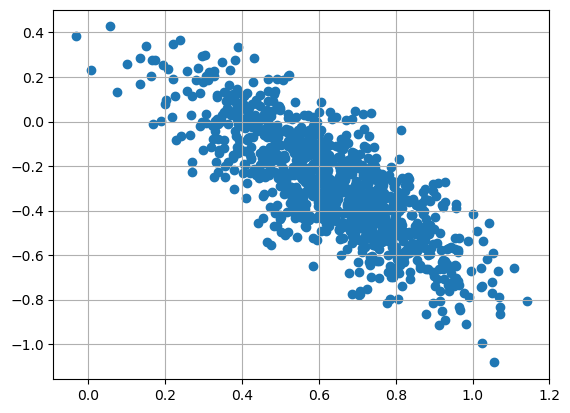

In [82]:
plt.scatter(nigeria_mms_shifts.shift1, nigeria_mms_shifts.shift2)
plt.grid()

In [83]:
location_id=165
pakistan_mms_shifts = pd.DataFrame()
for draw in list(range(0,1000)):
    shift1, shift2 = mms_double_shift(draw, location_id)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    pakistan_mms_shifts = pd.concat([pakistan_mms_shifts, temp], ignore_index=True)
pakistan_mms_shifts['location_id'] = location_id
pakistan_mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.722342,-0.301083,165
1,draw_1,0.952003,-0.797246,165
2,draw_2,0.005697,0.221313,165
3,draw_3,0.744255,-0.449123,165
4,draw_4,0.721075,-0.267329,165
...,...,...,...,...
995,draw_995,0.557068,-0.368624,165
996,draw_996,0.552233,-0.226072,165
997,draw_997,0.440763,0.287802,165
998,draw_998,0.742808,-0.222292,165


In [84]:
ethiopia_mms_shifts['location_id'] = 179
mms_shifts = pd.concat([ethiopia_mms_shifts,
                       nigeria_mms_shifts,
                       pakistan_mms_shifts], ignore_index=True)
mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.679787,-0.247961,179
1,draw_1,0.897761,-0.746363,179
2,draw_2,0.005840,0.226187,179
3,draw_3,0.667505,-0.378774,179
4,draw_4,0.684519,-0.249751,179
...,...,...,...,...
2995,draw_995,0.557068,-0.368624,165
2996,draw_996,0.552233,-0.226072,165
2997,draw_997,0.440763,0.287802,165
2998,draw_998,0.742808,-0.222292,165


In [85]:
mms_shifts.to_csv('updated_mms_shifts.csv')

In [86]:
covered_exp

,location_id,age_group_id,sex_id,parameter,ga_start,ga_end,bw_start,bw_end,draw,exposure,covered_shift,frac_ptb,exposure_ptb,frac_vptb,exposure_vptb
0,214,164,1,cat2,0.033716,24.033716,0,500,draw_0,0.000764,0.033716,1.0,0.000764,1.0,0.000764
1,214,164,2,cat2,0.033716,24.033716,0,500,draw_0,0.000585,0.033716,1.0,0.000585,1.0,0.000585
2,214,164,1,cat8,0.033716,24.033716,500,1000,draw_0,0.000782,0.033716,1.0,0.000782,1.0,0.000782
3,214,164,2,cat8,0.033716,24.033716,500,1000,draw_0,0.000851,0.033716,1.0,0.000851,1.0,0.000851
4,214,164,1,cat10,24.033716,26.033716,500,1000,draw_0,0.000558,0.033716,1.0,0.000558,1.0,0.000558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347995,165,164,1,cat116,38.062627,40.062627,1000,1500,draw_999,0.008327,0.062627,0.0,0.000000,0.0,0.000000
347996,165,164,2,cat117,38.062627,40.062627,1500,2000,draw_999,0.018685,0.062627,0.0,0.000000,0.0,0.000000
347997,165,164,1,cat117,38.062627,40.062627,1500,2000,draw_999,0.016154,0.062627,0.0,0.000000,0.0,0.000000
347998,165,164,2,cat123,40.062627,42.062627,1500,2000,draw_999,0.005273,0.062627,0.0,0.000000,0.0,0.000000


In [87]:
# ok, now for some validation
mms_exp_val = covered_exp.merge(mms_shifts, on=['draw','location_id'])
mms_exp_val['ga_start'] = mms_exp_val.ga_start + mms_exp_val.shift1
mms_exp_val['ga_end'] = mms_exp_val.ga_end + mms_exp_val.shift1
mms_exp_val['frac_shift2'] = np.where(mms_exp_val.ga_start < (32 - mms_exp_val.shift2), 0, 1)
mms_exp_val['ga_start'] = mms_exp_val.ga_start + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)
mms_exp_val['ga_end'] = mms_exp_val.ga_end + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)

mms_exp_val['exposure_vptb'] = np.where(mms_exp_val.ga_start >= 32, 0,
                                            np.where(mms_exp_val.ga_end < 32, mms_exp_val.exposure,
                                                    ((32 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                     * mms_exp_val.exposure)))
mms_exp_val['exposure_ptb'] = np.where(mms_exp_val.ga_start >= 37, 0,
                                        np.where(mms_exp_val.ga_end < 37, mms_exp_val.exposure,
                                                ((37 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                 *mms_exp_val.exposure)))
mms_exp_val = mms_exp_val.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
mms_exp_val

/tmp/ipykernel_3250253/996656630.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mms_exp_val = mms_exp_val.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]


exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_0        0.291688       0.050882
            draw_1        0.306708       0.044338
            draw_10       0.288678       0.054617
            draw_100      0.284223       0.048571
            draw_101      0.311144       0.053077
...                            ...            ...
214         draw_995      0.305024       0.049280
            draw_996      0.294226       0.049225
            draw_997      0.263102       0.051680
            draw_998      0.279913       0.047186
            draw_999      0.320853       0.041886

[3000 rows x 2 columns]

In [88]:
rrs = mms_exp_val / covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
rrs

/tmp/ipykernel_3250253/3982770509.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rrs = mms_exp_val / covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]


exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_0        0.890218       0.794304
            draw_1        0.960964       0.729099
            draw_10       0.887109       0.830840
            draw_100      0.913867       0.830919
            draw_101      0.950154       0.839002
...                            ...            ...
214         draw_995      0.952573       0.836751
            draw_996      0.916551       0.839278
            draw_997      0.815816       0.872531
            draw_998      0.873483       0.792088
            draw_999      0.992538       0.694967

[3000 rows x 2 columns]

In [89]:
print('Validation target is: ',mms_pt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_pt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_pt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_ptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.911  (95% CI:  0.842 ,  0.991 )


mean     0.911483
2.5%     0.841890
97.5%    0.990781
Name: exposure_ptb, dtype: float64

In [90]:
print('Validation target is: ',mms_vpt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_vpt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_vpt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_vptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.811  (95% CI:  0.712 ,  0.923 )


mean     0.810772
2.5%     0.712366
97.5%    0.923485
Name: exposure_vptb, dtype: float64